## stacking 集成算法：次级学习器融合-线性模型
- 1.Lasso回归
- 2.岭回归
- 3.ElasticNetCV

In [1]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
from IPython.display import display

#应该是设置浮点数的形式格式，小数点后三位
pd.set_option('display.float_format', lambda x: '%.4f' % x)

#这一行是干嘛的？ 设置 matplotlib 让绘制的图形出现在 Notebook 里而不是新窗口
%matplotlib inline

In [2]:
def get_train_val(val_id):
    '''获取训练集和校验集 
    val_id = 0,1,2 #当前校验集编号 '''
    print('val_id=%s'% (val_id))
    df_val = train_list[val_id]
    train_tmp = []

    for i in range(1, train_part_num):
        cur_id = (val_id + i) % 5
        print('cur_id=%s'% (cur_id))
        train_tmp.append(train_list[cur_id])
    
#     只生成一次，节省内存 
    df_train = pd.concat(train_tmp)
    print('df_train.shape=%s  df_val.shape=%s'% (df_train.shape, df_val.shape))
    return df_train, df_val

In [3]:
Y_Standard = True
path_train = '../data/new/train=predict/'
path_test = '../data/new/test=predict/'

val_path = '../data/val/second/' #保存校验集测试结果
val_name = '%sval=stacking-%s-%s.csv'
summit_path = '../data/summit/stacking-second/' #保存提交文件，测试集测试结果 
out_name = '%ssummit=stacking-%s-%s.csv' # 生成的结果文件名称
base = 'second' #学习器级别 

train_part_num = 5 #训练集拆分个数
target = 'prediction_pay_price'
user_id = 'user_id'

## 指定读取数据类型，节省内存

In [4]:
col_int32 = ['user_id']
col_float32 = ['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7']

In [5]:
# 指定读取数据类型，节省内存
dtype_test = {}
for col in col_int32:
    dtype_test[col] = np.int32
for col in col_float32:
    dtype_test[col] = np.float32
# dtype_test

In [6]:
dtype_train = dtype_test.copy()
dtype_train[target] = np.float32
# dtype_train

## 读取数据，一次读取多次使用，不同组合 

In [7]:
train_list = []
for i in range(train_part_num):
    cur_id = i + 1
    train_list.append(pd.read_csv('%strain=pred-1-col=9-target-%s.csv' % (path_train, cur_id), dtype=dtype_train))
train_list[0].head()

,user_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,prediction_pay_price
0,332994,0.0000,0.0001,0.0000,0.3495,0.0001,0.0000,0.0000,0.0001,0.0000
1,2186887,0.1648,0.0001,0.0000,0.3495,0.0046,0.0000,0.1085,0.0002,0.0000
2,383991,0.1635,0.0001,0.0000,0.3495,0.0001,0.0000,0.0527,0.0001,0.0000
3,102315,0.1576,0.0001,0.0000,0.3495,0.0002,0.0000,0.0576,0.0001,0.0000
4,225310,0.0000,0.0001,0.0000,0.3495,0.0007,0.0000,0.0131,0.0001,0.0000


## 5折交叉验证

In [8]:
# 根据校验集编号 0，1,2,3,4 ，获取训练集和校验集
df_train, df_val = get_train_val(1)

# 从原始数据中分离输入特征x和输出y
train_y = df_train[target].values
train_X = df_train.drop([target, user_id], axis = 1)
val_y = df_val[target].values
val_X = df_val.drop([target, user_id], axis = 1)

val_id=1
cur_id=2
cur_id=3
cur_id=4
cur_id=0
df_train.shape=(1830406, 10)  df_val.shape=(457601, 10)


In [9]:
# 数据标准化：分别初始化对特征和目标值的标准化器 
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
train_X_ss = ss_X.fit_transform(train_X)
val_X_ss = ss_X.transform(val_X)

if Y_Standard:
    train_y_ss = ss_y.fit_transform(train_y.reshape(-1, 1))
    val_y_ss = ss_y.transform(val_y.reshape(-1, 1))

# 需要转换为一维数组 
train_y_ss_1d = train_y_ss.reshape(train_y_ss.shape[0])
val_y_ss_1d = val_y_ss.reshape(val_y_ss.shape[0])

In [10]:
def inverse_StandardScaler(predict):
    ''' 标准化数据还原  '''
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

def generate_summit(predict):
    ''' 输出预测后的数据 '''
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

def generate_val_predict(predict):
    ''' 生成校验集预测后的数据 '''
    testPredict = df_val.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 模型训练
### 1.正则化的线性回归（L1正则 --> Lasso）

In [34]:
%%time
# alphas = [0.1, 10, 100, 1000, 10000]
alphas = [0.0001, 0.0007, 0.0009, 0.001, 0.0011, 0.0013, 0.01]

lasso = LassoCV(alphas=alphas)
lasso.fit(train_X_ss, train_y_ss_1d)
print ('best_alpha=', lasso.alpha_)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best_alpha= 0.0009
Wall time: 55.9 s


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best alpha is: 0.0009


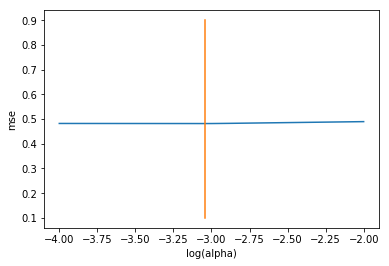

In [35]:
## 3.1 Lasso 模型评价
mses = np.mean(lasso.mse_path_, axis=1)

#plt.plot(np.log10(alphas), mses)
plt.plot(np.log10(lasso.alphas_), mses)
# plt.show()  #绘制在一张图上，显示异常，暂时分开 

plt.plot(np.log10(lasso.alpha_)*np.ones(3), [0.1, 0.5, 0.9])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
# plt.show() 
print ('best alpha is:', lasso.alpha_)
# best alpha is: 10.5

In [36]:
# 模型评估
lassoScoreTrain = lasso.score(train_X_ss, train_y_ss)
lassoScoreVal = lasso.score(val_X_ss, val_y_ss)
print('The score: Train=%s  Val=%s'% (lassoScoreTrain, lassoScoreVal)) 

lasso_predict_train = lasso.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss, lasso_predict_train) ** 0.5
lasso_predict_val = lasso.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss, lasso_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score: Train=0.6026498641616385  Val=0.8354317552131078
# The RMSE: Train=0.6303571494306712  Val=0.5921995943739873

The score: Train=0.5389420401278865  Val=0.5629097766727182
The RMSE: Train=0.6790125188555122  Val=0.48957351186366377


### 保存校验集测试结果

In [37]:
print('lasso_predict_val= ', lasso_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(lasso_predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'lasso'), index=False)
valPredict.head()

lasso_predict_val=  [ 0.18614219 -0.0226332  -0.02254944 ... -0.02250223 -0.02250246
 -0.02250245]
predict =  [19.10429599 -0.25985211 -0.25208378 ... -0.24770466 -0.24772588
 -0.24772452]


,user_id,prediction_pay_price
0,1098285,19.1043
1,2550284,0.0000
2,3456,0.0000
3,1561684,0.0000
4,2342396,0.0000


## 加载测试数据

In [38]:
test = pd.read_csv(path_test + 'test=pred-1-col=9.csv', dtype=dtype_test)
test_X = test.drop([user_id], axis = 1)
test_X_ss = ss_X.transform(test_X)
test.head()

,user_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7
0,14933,0.0842,0.0002,0.0079,0.4069,0.0001,0.0102,1.6502,0.0002
1,14934,0.0592,0.0001,0.0000,0.4069,0.0000,0.0000,0.6719,0.0001
2,14935,0.3927,0.0001,0.0000,0.4069,0.0000,0.0000,0.9312,0.0001
3,14936,1.5131,0.0063,0.2355,0.4069,0.0000,0.2351,1.3646,0.0001
4,14937,0.0000,0.0001,0.0000,0.4069,0.0000,0.0000,0.5996,0.0001


In [39]:
#对测试数据进行预测
lasso_y_predict_test = lasso.predict(test_X_ss)
print('lasso_y_predict_test = ', lasso_y_predict_test)

# 标准化数据还原 
lasso_y_predict_test = inverse_StandardScaler(lasso_y_predict_test)
# lasso_y_predict_test =  [0.4556051 0.4556051 0.4556051 ... 0.4556051 0.4556051 0.4556051]

lasso_y_predict_test =  [-0.02037526 -0.02182029 -0.02413282 ... -0.01998081 -0.02435788
 -0.02565688]
predict =  [-0.05042612 -0.18445373 -0.39894381 ... -0.01384044 -0.4198179
 -0.5403017 ]


In [40]:
testPredict = generate_summit(lasso_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'lasso'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000


## 2 正则化的线性回归（L2正则 --> 岭回归）

In [44]:
%%time
#正则项的参数
# alphas = [0.1, 1, 10, 100, 10000]
alphas = [0.1, 7000,9000,10000,11000,13000, 20000, 100000]
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(train_X_ss, train_y_ss_1d)
print('best alpha is:', ridge.alpha_)

best alpha is: 13000.0
Wall time: 3.2 s


best alpha is: 13000.0


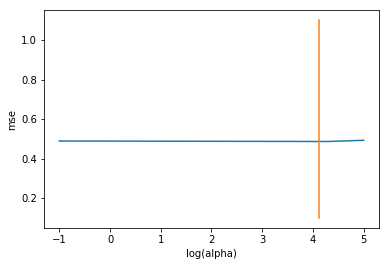

In [45]:
### 2.1 岭回归模型评价
mse_mean = np.mean(ridge.cv_values_, axis=0)

#正则项参数取对数， mse_mean.reshape() 干什么的？拉平
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas), 1))
# 在最佳参数位置绘制竖线：注意第二个参数值要和 Y 坐标轴匹配
plt.plot(np.log10(ridge.alpha_)*np.ones(3), [.1, .5, 1.1])
# plt.show() #绘制在一张图上，显示异常，暂时分开 

plt.xlabel('log(alpha)')
plt.ylabel('mse')
print('best alpha is:', ridge.alpha_)

In [46]:
# 模型评估
ridgeScoreTrain = ridge.score(train_X_ss, train_y_ss_1d)
ridgeScoreVal = ridge.score(val_X_ss, val_y_ss_1d)
print('The score: Train=%s  Val=%s'% (ridgeScoreTrain, ridgeScoreVal)) 

ridge_predict_train = ridge.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, ridge_predict_train) ** 0.5
ridge_predict_val = ridge.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, ridge_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score: Train=0.6886471998505836  Val=0.5049070896778365
# The RMSE: Train=0.5579899841294994  Val=0.8149389859862378

The score: Train=0.5376756461388056  Val=0.5687510823437216
The RMSE: Train=0.6799444057155719  Val=0.48629116049571464


### 保存校验集测试结果

In [47]:
print('ridge_predict_val= ', ridge_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(ridge_predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'RidgeCV'), index=False)
valPredict.head()

ridge_predict_val=  [ 0.17404986 -0.02277073 -0.02267068 ... -0.02266886 -0.02266911
 -0.02266912]
predict =  [17.98271904 -0.27260777 -0.26332874 ... -0.26315979 -0.26318289
 -0.26318395]


,user_id,prediction_pay_price
0,1098285,17.9827
1,2550284,0.0000
2,3456,0.0000
3,1561684,0.0000
4,2342396,0.0000


In [48]:
#对测试数据进行预测
ridge_y_predict_test = ridge.predict(test_X_ss)
print('ridge_y_predict_test = ', ridge_y_predict_test)

# 标准化数据还原 
ridge_y_predict_test = inverse_StandardScaler(ridge_y_predict_test)

ridge_y_predict_test =  [-0.02055419 -0.02196453 -0.02369188 ... -0.01994326 -0.0240359
 -0.02501103]
predict =  [-0.06702143 -0.19783264 -0.35804581 ... -0.01035768 -0.38995415
 -0.48039867]


In [49]:
# ridge_y_predict_test = move_up(ridge_y_predict_test)
#输出预测后的数据
testPredict = generate_summit(ridge_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'RidgeCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000


### 3. 正则化的线性回归 ElasticNetCV 

In [24]:
%%time
# l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
l1_ratio = [.99, 1]

model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.001) #效果最好
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.005)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.0005)
model.fit(train_X_ss, train_y_ss_1d)
print ('best alpha is:%s  l1_ratio_:%s' % (model.alpha_, model.l1_ratio_))
# best alpha is:0.023491824547378765  l1_ratio_:1.0
# Wall time: 1min 17s

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best alpha is:0.0007220471250411319  l1_ratio_:1.0
Wall time: 1min 4s


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best alpha is:0.0007220471250411319  l1_ratio_:1.0


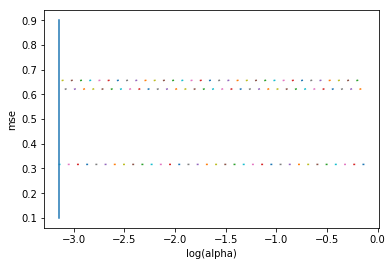

In [25]:
## 3.1 Lasso 模型评价
mses = np.mean(model.mse_path_, axis=1)
plt.plot(np.log10(model.alphas_), mses)

plt.plot(np.log10(model.alpha_)*np.ones(3), [0.1, 0.5, .9])
plt.xlabel('log(alpha)')
plt.ylabel('mse')

print ('best alpha is:%s  l1_ratio_:%s' % (model.alpha_, model.l1_ratio_))
# best alpha is:0.023491824547378765  l1_ratio_:1.0

In [26]:
# 模型评估
scoreTrain = model.score(train_X_ss, train_y_ss_1d)
scoreVal = model.score(val_X_ss, val_y_ss_1d)
print('The score of model: Train=%s  Val=%s'% (scoreTrain, scoreVal)) 

predict_train = model.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, predict_train) ** 0.5
predict_val = model.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score of model: Train=0.5770046284899812  Val=0.6397112081154743
# The RMSE: Train=0.6503808356107215  Val=0.7399599188801825

The score of model: Train=0.5389981190700723  Val=0.5621325522831966
The RMSE: Train=0.6789712231128414  Val=0.49000859305608635


### 保存校验集测试结果

In [27]:
print('predict_val= ', predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'ElasticNetCV'), index=False)
valPredict.head()

predict_val=  [ 0.187467   -0.02262678 -0.02254496 ... -0.0224934  -0.02249364
 -0.02249363]
predict =  [19.2271734  -0.25925686 -0.25166777 ... -0.24688597 -0.24690803
 -0.2469068 ]


,user_id,prediction_pay_price
0,1098285,19.2272
1,2550284,0.0000
2,3456,0.0000
3,1561684,0.0000
4,2342396,0.0000


In [28]:
#对测试数据进行预测
predict_test = model.predict(test_X_ss)
print('predict_test = ', predict_test)

# 标准化数据还原 
predict_test_true = inverse_StandardScaler(predict_test)

predict_test =  [-0.02036204 -0.021812   -0.02417209 ... -0.01995165 -0.02438795
 -0.02571328]
predict =  [-0.04919949 -0.1836852  -0.40258547 ... -0.01113516 -0.42260736
 -0.54553296]


In [29]:
testPredict = generate_summit(predict_test_true)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'ElasticNetCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000
